<a href="https://colab.research.google.com/github/sebgrijalva/Cirq-code/blob/master/QOSF/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip3 install cirq
import random
import cirq

In [0]:
#needed for classical post-processing and evaluation;
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

iteration 0: parameter = 1.1315678486974647, error = 0.20839999999999995
iteration 1: parameter = 0.3478838486974647, error = 0.768736
iteration 2: parameter = -1.4264555113025352, error = 0.051396
iteration 3: parameter = -1.3678861113025351, error = 0.08326399999999998
iteration 4: parameter = -1.451468791302535, error = 0.047395999999999994

 Counter({'[0 0]': 523, '[1 1]': 437, '[0 1]': 22, '[1 0]': 18}) 

Circuit:
(0, 0): ───D(0.05)───Ry(-0.462π)───@───M('result')───
                                   │   │
(0, 1): ───D(0.05)─────────────────X───M───────────── 
 Details:


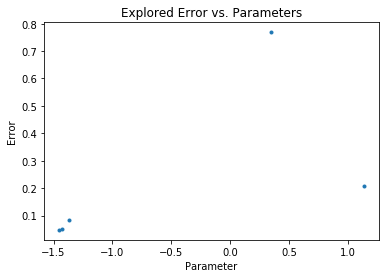

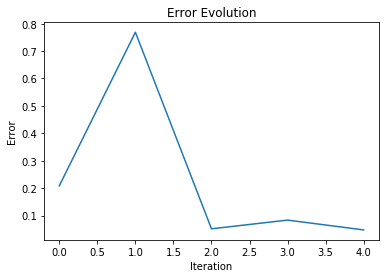

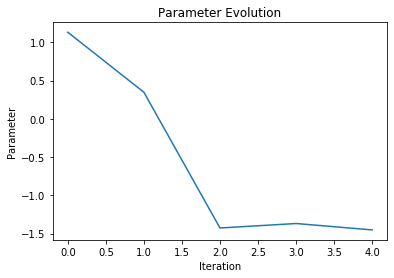

In [358]:
def main(qubit_count = 2):

    n_samples = 1000
    parameter = 2*np.pi*(random.random()-1/2) #starting with our parameter somewhere btw -pi,pi

    error_data = []
    parameter_data = [parameter]
    error = 1
    step = 0.01 #for gradient descent

    # Choose qubits to use.
    input_qubits = [cirq.GridQubit(0,0),cirq.GridQubit(0, 1)]
    
    scanning = True
    iterations = 0
    while scanning and iterations < 100:
        # Build circuit (with updated parameter):
        circuit = make_circuit(input_qubits, parameter)


        data=[] #we'll store here the results of the sampling

        # Sampling:
        ##############################################################
        for _ in range(n_samples):
            
            simulator = cirq.Simulator()
            results = simulator.run(circuit).measurements['result'][0]
            #print(results)
            data.append(str(results))
        

        #print(data)
        freqs = Counter(data)
            
        #Classical Post-Processing:   
        ##############################################################

        #Objective function is to cancel the amplitudes of the |01> and |10> states and to have the others equal.
        new_error = freqs['[0 1]']/n_samples + freqs['[1 0]']/n_samples + (freqs['[0 0]']/n_samples - freqs['[1 1]']/n_samples)**2
        
        error_data.append(new_error)
        print(f'iteration {iterations}: parameter = {parameter}, error = {new_error}')
        if new_error < 0.05: 
            scanning = False
        else: 
            # go against max descent and big error. If True, force symmetric state |00> + |11>. If False, force antisymmetric state |00> - |11>
            parameter += - step*(new_error - error) - np.sign(new_error - error)*new_error + get_sym_state(parameter,False)
            error = new_error
            parameter_data.append(parameter)

        iterations += 1

    #Show Results:
    ######################################################    
    print('\n',freqs,'\n')  # get an idea of what was the final frequency count
    print('Circuit:')
    print(circuit,'\n','Details:')

    plt.figure(0)
    plt.title('Explored Error vs. Parameters')
    plt.xlabel('Parameter')
    plt.ylabel('Error')
    plt.plot(parameter_data,error_data,'.')

    plt.figure(1)
    plt.title('Error Evolution')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.plot(range(len(error_data)),error_data)
            
    plt.figure(2)
    plt.title('Parameter Evolution')
    plt.xlabel('Iteration')
    plt.ylabel('Parameter')
    plt.plot(range(len(parameter_data)),parameter_data)
    
    
def get_sym_state(parameter, choice):
    if choice:
        return np.heaviside(-parameter,0)
    else:
        return - np.sign(parameter)*np.heaviside(parameter,0) 


def make_circuit(qubits,theta):
    """Generates a state with equal probability of being in |00> and |11>"""

    c = cirq.Circuit()
    
    c.append([
        # add noise (5% probability of getting some Pauli gates scrambling our system)
        cirq.DepolarizingChannel(0.05).on(qubits[0]), 
        cirq.DepolarizingChannel(0.05).on(qubits[1]),
        
        # put gates in the circuit
        cirq.ry(theta)(qubits[0]),
        cirq.CNOT(qubits[0],qubits[1]),

        # measure state
        cirq.measure(*qubits, key='result')
    ])

    return c

if __name__ == '__main__':
    main()